# Import packages

In [1]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import dill
from pysal.viz import splot
import contextily
import geopandas as gpd
import numba
from pysal.explore import esda
from pysal.lib import weights
from esda.join_counts_local import Join_Counts_Local
from numpy.random import seed
from shapely.geometry import Point, Polygon
from splot import esda as esdaplot
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe
import scipy.stats
from scipy.stats import chi2
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import f_classif
from matplotlib import colors

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# about warning message: https://gis.stackexchange.com/questions/397482/what-does-this-warning-mean-for-shapely-python

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# long/lat boundary of our Bradford county study region

PA_long_min = -76.98
PA_long_max = -76.06
PA_lat_min = 41.5
PA_lat_max = 42.01

PA_long_list = [PA_long_min,PA_long_min,PA_long_max,PA_long_max]
PA_lat_list = [PA_lat_max, PA_lat_min, PA_lat_min, PA_lat_max]

# Import dataset

In [3]:
df = pd.read_csv('./data/LI_et_al_well_parameter_dataset.csv')
df_trim = df.drop(['Unnamed: 0', 'api', 'latitude', 'longitude'], axis = 1)

# One-hot encoding and missing value imputation

In [4]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude=["object", 'bool'])),
        ("cat", categorical_transformer, selector(dtype_include=["object"])),
    ],
    remainder = 'passthrough'
)

In [5]:
data_pro = preprocessor.fit_transform(df_trim)
pre_pro_cols = preprocessor.get_feature_names_out()
pre_pro_cols = np.array([s.removeprefix('cat__').removeprefix('num__').removeprefix('remainder__') for s in pre_pro_cols])
pre_pro_cols = np.array([s.replace('_' , ' ') for s in pre_pro_cols])
df_pro = pd.DataFrame(data_pro, columns = pre_pro_cols)
# append back api and lat/long columns:
df_pro['api'] = df['api']
df_pro['latitude'] = df['latitude']
df_pro['longitude'] = df['longitude']

# Make GeoDataFrame

In [6]:
crs = 'epsg:4326'
geometry_df_pro = [Point(xy) for xy in zip(df_pro['longitude'],df_pro['latitude'])]
geo_df_pro = gpd.GeoDataFrame(df_pro, crs = crs, geometry = geometry_df_pro)

# Add topography info

In [7]:
# Get the topography layer
penn_map = gpd.read_file("./shape_files/topography/theobald_classes_v2/theobald_classes_polygon.shp")
penn_map = penn_map.to_crs(crs)

In [8]:
# join the geo_df with topographical information
geo_df_pro = geo_df_pro.sjoin(penn_map, how="left", predicate='within')

# Add folds info

In [9]:
# read in and clip folds:
PA_folds = gpd.read_file('./shape_files/folds/Pennsylvania_Folds/Pennsylvania_Folds.shp')
PA_folds = PA_folds.to_crs(crs)

In [10]:
polygon_geom_PA = Polygon(zip(PA_long_list, PA_lat_list))
polygon_PA = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom_PA])

PA_folds_clip = gpd.clip(PA_folds, polygon_PA)
PA_folds_clip['coords'] = PA_folds_clip['geometry'].apply(lambda x: x.representative_point().coords[:])
PA_folds_clip['coords'] = [coords[0] for coords in PA_folds_clip['coords']]

# Spatial Autocorrelation Analysis

In [11]:
xys = pd.DataFrame({"X": geo_df_pro.geometry.x, "Y": geo_df_pro.geometry.y})
min_thr = weights.util.min_threshold_distance(xys) + 0.001
w_min = weights.DistanceBand.from_array(xys.to_numpy(), min_thr)

## Join count

In [12]:
seed(1234)
jc = esda.join_counts.Join_Counts(geo_df_pro["scp and or cvf"], w_min)
print('Black-black, Black-white: ',jc.bb, jc.bw)
print('Mean Black-black, Mean Black-white',jc.mean_bb,jc.mean_bw)

Black-black, Black-white:  8259.0 13123.0
Mean Black-black, Mean Black-white 6277.437437437437 13940.805805805805


In [13]:
print('Simulated p-value of Black-black and Black-white: ',jc.p_sim_bb, jc.p_sim_bw)

Simulated p-value of Black-black and Black-white:  0.001 1.0


## Getis and Ord’s G

In [14]:
np.random.seed(10)
w_go = w_min
w_go.transform = 'R'
gao = esda.G(geo_df_pro['scp and or cvf'], w_go)
print(
    "Getis & Ord G (standardized): %.3f | Pseudo P-value: %.3f" % (gao.z_sim, gao.p_sim)
)

Getis & Ord G (standardized): 7.233 | Pseudo P-value: 0.001


# Local spatial autocorrelation analysis

## Local join counts

In [15]:
np.random.seed(10)
w_ljc = w_min
LJC_scp_cvf = Join_Counts_Local(connectivity=w_ljc, seed=10).fit(geo_df_pro['scp and or cvf'])
geo_df_pro['scp_cvf_LJC'] = LJC_scp_cvf.LJC
geo_df_pro['scp_cvf_LJC_p_sim'] = LJC_scp_cvf.p_sim

In [16]:
#cmap = matplotlib.cm.get_cmap('Greys')
cmap = matplotlib.colormaps['Greys']
color1 = colors.rgb2hex(cmap(0.1)[:3])
color2 = colors.rgb2hex(cmap(0.33)[:3])
color3 = colors.rgb2hex(cmap(0.66)[:3])
color4 = colors.rgb2hex(cmap(0.99)[:3])

color_dict = {'Peak':color4, 
            'Upper slope':color3,
            'Lower slope':color2,
            'Valley': color1}

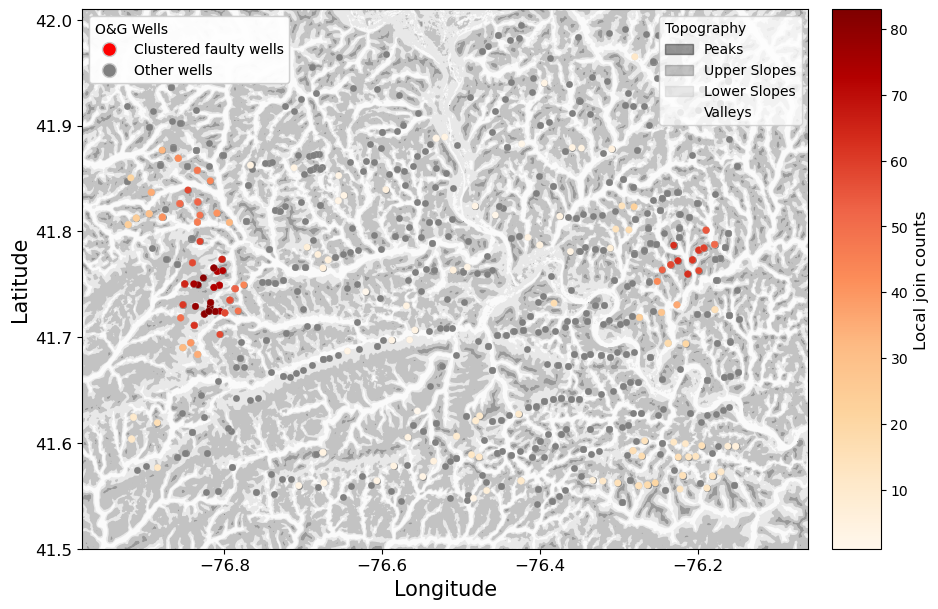

In [17]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_xlim(PA_long_min,PA_long_max)
ax.set_ylim(PA_lat_min, PA_lat_max)
# plot topography:
for ctype, data in penn_map.groupby('topoclass'):
        data.plot(color = color_dict[ctype], 
                  label = ctype,
                  ax = ax,
                  alpha=0.4)
        
# legend showing topography:
legend_elements_topo = [Patch(facecolor=color4, edgecolor=color4,
                         label='Peaks', alpha=0.4),
                   Patch(facecolor=color3, edgecolor=color3,
                         label='Upper Slopes', alpha=0.4),
                   Patch(facecolor=color2, edgecolor=color2,
                         label='Lower Slopes', alpha=0.4),
                   Patch(facecolor=color1, edgecolor=color1,
                         label='Valleys', alpha=0.4)
                  ]
legend_topo = ax.legend(handles = legend_elements_topo, loc = 'upper right',title = 'Topography', prop = {'size':10})
ax.add_artist(legend_topo)
legend_topo.get_title().set_fontsize('10')
legend_topo._legend_box.align = "left"        
        
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-1)
ec = "0.8"

# plot non-significant wells:
geo_df_ns = geo_df_pro.loc[~(geo_df_pro['scp_cvf_LJC_p_sim']<0.05), :]
geo_df_ns.plot(ax=ax, color="grey", edgecolor=ec, linewidth=0.1, markersize = 25, label = 'Other wells')

# plot hot spots:
geo_df_hot = geo_df_pro.loc[geo_df_pro['scp_cvf_LJC_p_sim']<0.05, :]
geo_df_hot.plot(ax=ax, column='scp_cvf_LJC',legend=True, edgecolor=ec, linewidth=0.1,markersize = 25,cmap = 'OrRd',cax = cax, label = 'Clustered faulty wells with significance')

# Formatting colorbar:
cax.set_ylabel('Local join counts', fontsize=12)
cax.tick_params(axis='both', which='major', labelsize=10) 

# Legend showing wells
legend_elements_well = [
    Line2D([0], [0], color='red', linestyle='none', marker='o', markeredgecolor=ec, label='Clustered faulty wells',
                           markersize=10),
    Line2D([0], [0], color='grey', linestyle='none', marker='o', markeredgecolor=ec, label='Other wells',
                           markersize=10)
                  ]
legend_well = ax.legend(handles = legend_elements_well,loc = 'upper left', prop = {'size':10},title='O&G Wells')
ax.add_artist(legend_well)
legend_well.get_title().set_fontsize('10')
legend_well._legend_box.align = "left"

ax.set_xlabel('Longitude', fontsize = 15)
ax.set_ylabel('Latitude', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
f.tight_layout()

plt.savefig('./Figures/main_text/LJC_map.png',bbox_inches='tight',dpi=300)

# Locations of folds

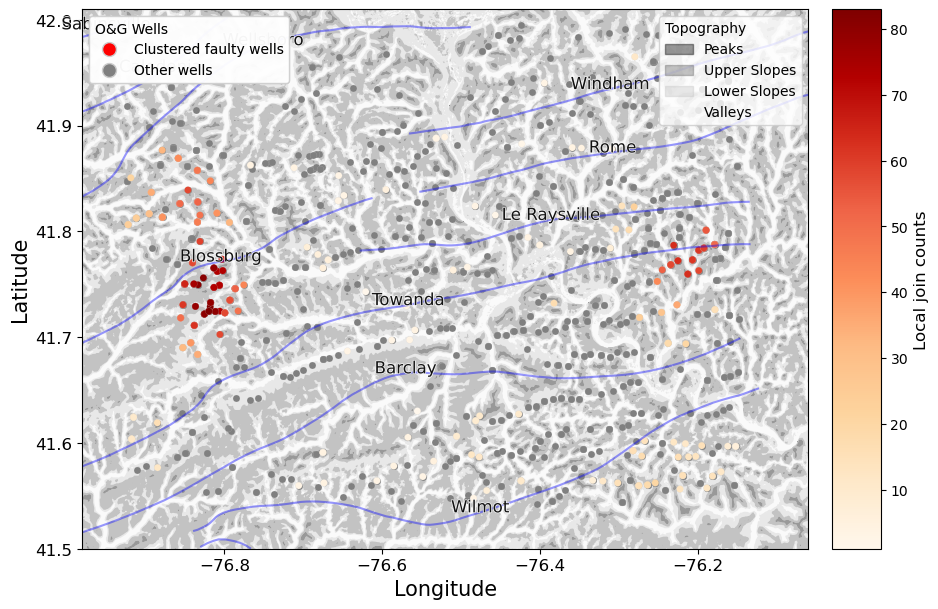

In [18]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_xlim(PA_long_min,PA_long_max)
ax.set_ylim(PA_lat_min, PA_lat_max)

# plot and annotate folds
PA_folds_clip.plot(ax=ax, color = 'blue', alpha = 0.4)
for idx, row in PA_folds_clip.iterrows():
    ax.annotate(text=row['NAME'], xy=row['coords'],
             horizontalalignment='center', fontsize = 12, alpha = 0.9,
                color = 'black', path_effects=[pe.withStroke(linewidth=1, foreground="white")])

# plot topography
for ctype, data in penn_map.groupby('topoclass'):
        data.plot(color = color_dict[ctype], 
                  label = ctype,
                  ax = ax,
                  alpha=0.4)
        
# legend showing topography
legend_elements_topo = [Patch(facecolor=color4, edgecolor=color4,
                         label='Peaks', alpha=0.4),
                   Patch(facecolor=color3, edgecolor=color3,
                         label='Upper Slopes', alpha=0.4),
                   Patch(facecolor=color2, edgecolor=color2,
                         label='Lower Slopes', alpha=0.4),
                   Patch(facecolor=color1, edgecolor=color1,
                         label='Valleys', alpha=0.4)
                  ]
legend_topo = ax.legend(handles = legend_elements_topo, loc = 'upper right',title = 'Topography', prop = {'size':10})
ax.add_artist(legend_topo)
legend_topo.get_title().set_fontsize('10')
legend_topo._legend_box.align = "left"        
        
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-1)
ec = "0.8"

# plot non-significant wells
geo_df_ns = geo_df_pro.loc[~(geo_df_pro['scp_cvf_LJC_p_sim']<0.05), :]
geo_df_ns.plot(ax=ax, color="grey", edgecolor=ec, linewidth=0.1, markersize = 25, label = 'Other wells')

# plot hot spots
geo_df_hot = geo_df_pro.loc[geo_df_pro['scp_cvf_LJC_p_sim']<0.05, :]
geo_df_hot.plot(ax=ax, column='scp_cvf_LJC',legend=True, edgecolor=ec, linewidth=0.1,markersize = 25,cmap = 'OrRd',cax = cax, label = 'Clustered faulty wells with significance')

# Formatting colorbar
cax.set_ylabel('Local join counts', fontsize=12)
cax.tick_params(axis='both', which='major', labelsize=10) 

# Legend showing wells
legend_elements_well = [
    Line2D([0], [0], color='red', linestyle='none', marker='o', markeredgecolor=ec, label='Clustered faulty wells',
                           markersize=10),
    Line2D([0], [0], color='grey', linestyle='none', marker='o', markeredgecolor=ec, label='Other wells',
                           markersize=10)
                  ]

legend_well = ax.legend(handles = legend_elements_well,loc = 'upper left', prop = {'size':10},title='O&G Wells')
ax.add_artist(legend_well)
legend_well.get_title().set_fontsize('10')
legend_well._legend_box.align = "left"

ax.set_xlabel('Longitude', fontsize = 15)
ax.set_ylabel('Latitude', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
f.tight_layout()

plt.savefig('./Figures/SI/LJC_map_folds.png',bbox_inches='tight',dpi=300)


# Local Gi* statistics for important predictors

In [19]:
num_predictors = ['amount in well ft rank 1 casing', 'amount in well ft rank 3 casing','cement total amount conductor casing sks', 'hole size inch rank 1 casing']

In [20]:
np.random.seed(10)
for var in num_predictors:
    go_i_star = esda.getisord.G_Local(geo_df_pro[var], w_go, transform = 'R', star=True)
    geo_df_pro[var+'_go_i_star_Zs'] = go_i_star.Zs
    geo_df_pro[var+'_go_i_star_p_sim'] = go_i_star.p_sim

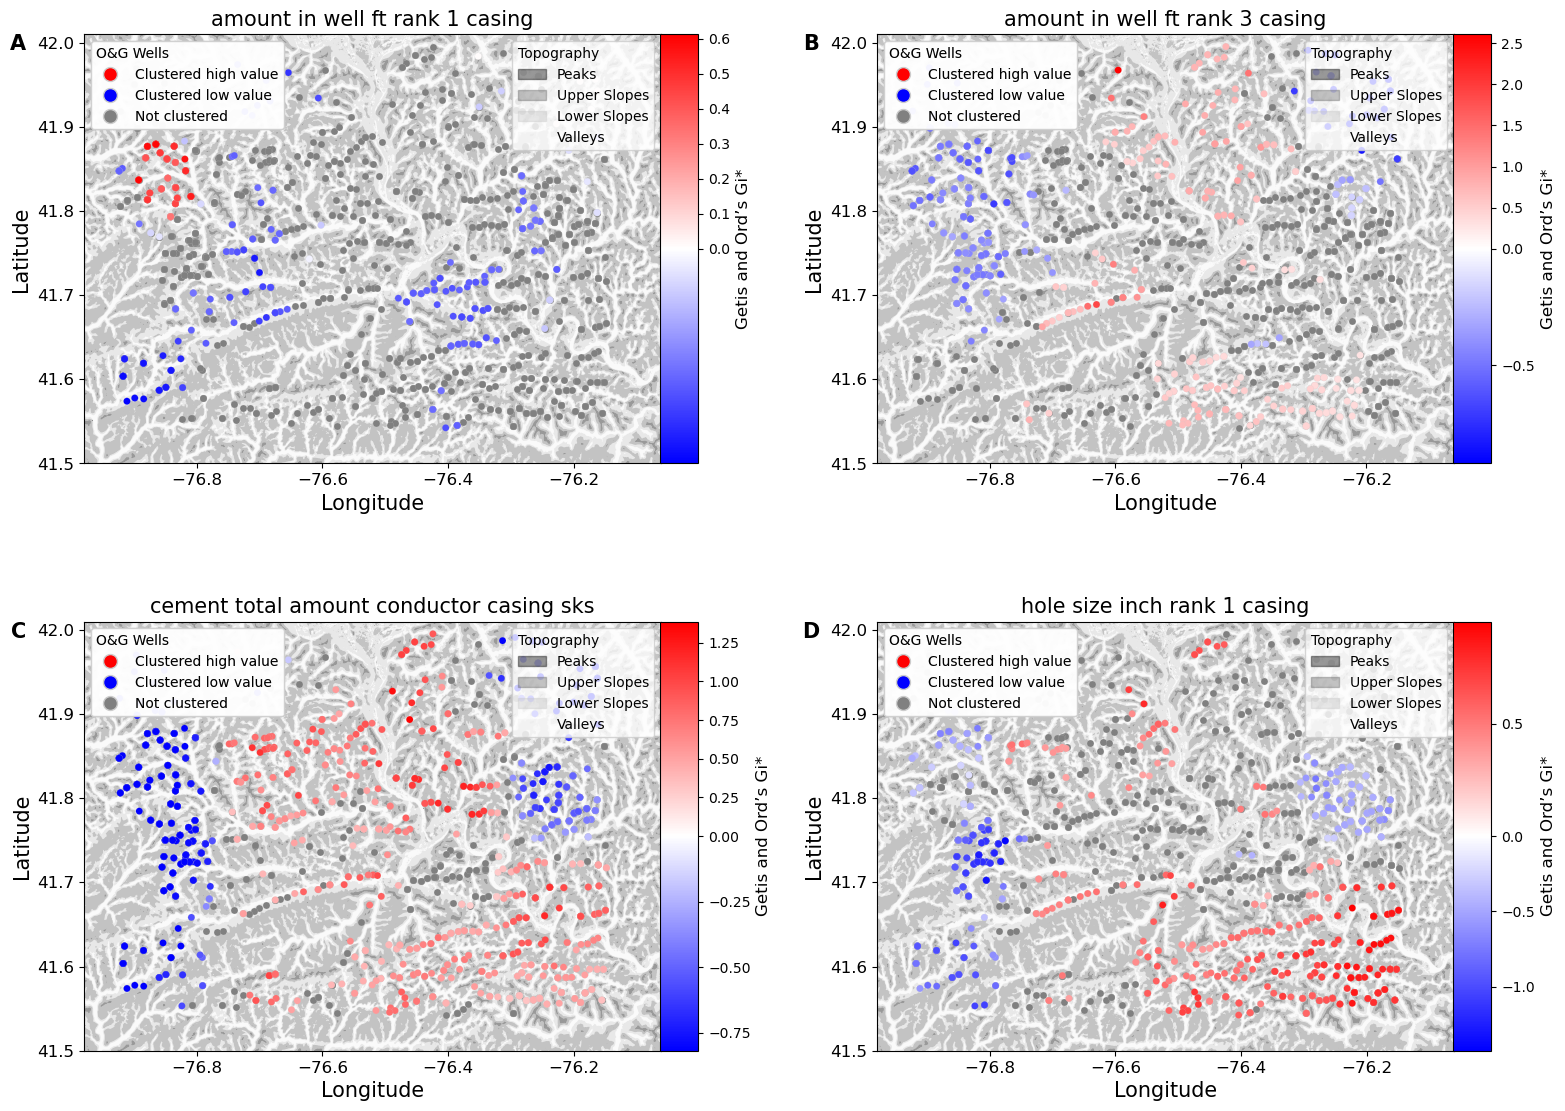

In [21]:
subplot_label=['A', 'B', 'C', 'D']

fig, axes = plt.subplots(2,2, figsize=(16, 12))

for i in range(len(num_predictors)):
    ax = axes.flatten()[i]
    var = num_predictors[i]
    ax.set_xlim(PA_long_min,PA_long_max)
    ax.set_ylim(PA_lat_min, PA_lat_max)
    # plot topography
    for ctype, data in penn_map.groupby('topoclass'):
            data.plot(color = color_dict[ctype], 
                      label = ctype,
                      ax = ax,
                      alpha=0.4)

    # legend showing topography
    legend_elements_topo = [Patch(facecolor=color4, edgecolor=color4,
                             label='Peaks', alpha=0.4),
                       Patch(facecolor=color3, edgecolor=color3,
                             label='Upper Slopes', alpha=0.4),
                       Patch(facecolor=color2, edgecolor=color2,
                             label='Lower Slopes', alpha=0.4),
                       Patch(facecolor=color1, edgecolor=color1,
                             label='Valleys', alpha=0.4)
                      ]

    legend_topo = ax.legend(handles = legend_elements_topo, loc = 'upper right',title = 'Topography', prop = {'size':10})
    ax.add_artist(legend_topo)
    legend_topo.get_title().set_fontsize('10')
    legend_topo._legend_box.align = "left"        

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-1)
    ec = "0.8"
    p_sim_col = var + '_go_i_star_p_sim'
    Zs_col = var + '_go_i_star_Zs'
    
    # plot non-significant wells  
    df_ns = geo_df_pro.loc[~(geo_df_pro[p_sim_col]<0.05), :]
    df_ns.plot(ax=ax, color="grey", edgecolor=ec, linewidth=0.1, markersize = 25)

    # plot hot spots    
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    df_hot = geo_df_pro.loc[geo_df_pro[p_sim_col]<0.05, :]
    df_hot.plot(ax=ax, column=Zs_col,legend=True, edgecolor=ec, linewidth=0.1,markersize = 25,cmap = 'bwr',norm=divnorm,cax = cax)

    # Formatting colorbar
    cax.set_ylabel('Getis and Ord’s Gi*', fontsize=12)
    cax.tick_params(axis='both', which='major', labelsize=10) 

    # Legend showing wells
    legend_elements_well = [
        Line2D([0], [0], color='red', linestyle='none', marker='o', markeredgecolor=ec, label='Clustered high value',
                               markersize=10, alpha = 1),
        Line2D([0], [0], color='blue', linestyle='none', marker='o', markeredgecolor=ec, label='Clustered low value',
                               markersize=10, alpha = 1),
        Line2D([0], [0], color='grey', linestyle='none', marker='o', markeredgecolor=ec, label='Not clustered',
                               markersize=10, alpha = 1)
                      ]

    legend_well = ax.legend(handles = legend_elements_well,loc = 'upper left', prop = {'size':10},title='O&G Wells')
    ax.add_artist(legend_well)
    legend_well.get_title().set_fontsize('10')
    legend_well._legend_box.align = "left"

    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel('Latitude', fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.text(-0.1, 1, subplot_label[i], transform=ax.transAxes, fontsize=15, fontweight='bold',va='top', ha='right')
    ax.set_title(var, fontsize = 15)
    
fig.tight_layout()
plt.savefig('./Figures/SI/Gi_star_num_predictors.png',bbox_inches='tight',dpi=300)